In [3]:
# Import required libraries for image processing and data analysis
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageEnhance, ImageOps
import random
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Define input and output paths for the garbage dataset
input_folder = '/kaggle/input/garbage/garbage-image-data'
output_folder = '/kaggle/working/processed_data'

print("Dataset input path:", input_folder)
print("Processed data output path:", output_folder)


Dataset input path: /kaggle/input/garbage/garbage-image-data
Processed data output path: /kaggle/working/processed_data


In [5]:
# Function to load and validate image files
def load_image(file_path):
    """
    Load image from file path and convert to RGB format
    Returns None if image is corrupted or cannot be loaded
    """
    try:
        # Open image using PIL
        image = Image.open(file_path)
        
        # Convert to RGB if image has alpha channel or other formats
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        # Check if image is too small (minimum 32x32 pixels)
        if image.size[0] < 32 or image.size[1] < 32:
            return None
            
        return image
    except:
        # Return None if any error occurs during loading
        return None

# Function to resize image to standard dimensions
def resize_image(image, size=(224, 224)):
    """
    Resize image to target size while maintaining quality
    Uses LANCZOS resampling for better quality
    """
    return image.resize(size, Image.Resampling.LANCZOS)


In [7]:
# Function to apply random rotation (±15-30 degrees)
def rotate_image(image):
    """
    Apply random rotation between -30 to +30 degrees
    Uses random angle in specified range for variety
    """
    # Random angle between -30 and +30 degrees
    angle = random.uniform(-30, 30)
    # Rotate image with white background fill
    return image.rotate(angle, expand=True, fillcolor=(255, 255, 255))

# Function to apply horizontal flip to image
def flip_horizontal(image):
    """
    Apply horizontal flip (left-right mirror)
    Creates horizontally flipped version of image
    """
    return ImageOps.mirror(image)

# Function to apply vertical flip to image
def flip_vertical(image):
    """
    Apply vertical flip (top-bottom mirror)
    Creates vertically flipped version of image
    """
    return ImageOps.flip(image)

# Function to apply zoom in/out effect
def zoom_image(image):
    """
    Apply random zoom in/out effect
    Zoom factor between 0.8 (zoom out) to 1.2 (zoom in)
    """
    # Get original image size
    width, height = image.size
    
    # Random zoom factor
    zoom_factor = random.uniform(0.8, 1.2)
    
    if zoom_factor < 1.0:
        # Zoom out - resize smaller then pad with white
        new_width = int(width * zoom_factor)
        new_height = int(height * zoom_factor)
        resized = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
        
        # Create new image with white background
        zoomed = Image.new('RGB', (width, height), (255, 255, 255))
        # Paste resized image in center
        x_offset = (width - new_width) // 2
        y_offset = (height - new_height) // 2
        zoomed.paste(resized, (x_offset, y_offset))
        return zoomed
    else:
        # Zoom in - resize larger then crop center
        new_width = int(width * zoom_factor)
        new_height = int(height * zoom_factor)
        resized = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
        
        # Crop center portion to original size
        x_offset = (new_width - width) // 2
        y_offset = (new_height - height) // 2
        return resized.crop((x_offset, y_offset, x_offset + width, y_offset + height))

# Function to adjust image brightness
def adjust_brightness(image):
    """
    Apply random brightness adjustment
    Factor ranges from 0.7 (darker) to 1.3 (brighter)
    """
    enhancer = ImageEnhance.Brightness(image)
    # Random brightness factor
    factor = random.uniform(0.7, 1.3)
    return enhancer.enhance(factor)

# Function to adjust image contrast
def adjust_contrast(image):
    """
    Apply random contrast adjustment
    Factor ranges from 0.8 (lower contrast) to 1.2 (higher contrast)
    """
    enhancer = ImageEnhance.Contrast(image)
    # Random contrast factor
    factor = random.uniform(0.8, 1.2)
    return enhancer.enhance(factor)


In [10]:
# Function to process a single image with optional augmentation
def process_one_image(file_path, add_effects=False):
    """
    Process single image: load, resize, and optionally apply augmentation
    add_effects=True applies random augmentation techniques
    add_effects=False only resizes the image
    """
    # Load the image
    image = load_image(file_path)
    if image is None:
        return None
    
    # Resize to standard dimensions
    image = resize_image(image)
    
    # Apply augmentation if requested
    if add_effects:
        # Randomly select one of 4 augmentation types
        effect_type = random.randint(1, 4)
        
        if effect_type == 1:
            # Apply rotation and resize again to maintain dimensions
            image = rotate_image(image)
            image = resize_image(image)
        elif effect_type == 2:
            # Apply horizontal flip
            image = flip_image(image)
        elif effect_type == 3:
            # Apply brightness adjustment
            image = change_brightness(image)
        elif effect_type == 4:
            # Apply contrast adjustment
            image = change_contrast(image)
    
    return image


In [11]:
# Main function to process entire dataset
def process_dataset():
    """
    Process complete garbage dataset with augmentation
    Creates processed and augmented versions of all images
    """
    # Create output directory
    os.makedirs(output_folder, exist_ok=True)
    
    # Initialize counters for statistics
    total_original = 0
    total_processed = 0
    category_stats = {}
    
    # Get all category folders
    categories = [d for d in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, d))]
    
    print(f"Found {len(categories)} categories: {categories}")
    
    # Process each category
    for category in categories:
        print(f"\nProcessing category: {category}")
        
        # Set up input and output paths for category
        category_input = os.path.join(input_folder, category)
        category_output = os.path.join(output_folder, category)
        os.makedirs(category_output, exist_ok=True)
        
        # Get all image files in category
        files = os.listdir(category_input)
        image_files = [f for f in files if f.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp'))]
        
        # Initialize category counters
        category_processed = 0
        category_augmented = 0
        
        # Process each image in category
        for filename in image_files:
            file_path = os.path.join(category_input, filename)
            name_only = filename.split('.')[0]
            
            # Process original image (no augmentation)
            original = process_one_image(file_path, add_effects=False)
            if original:
                # Save original processed image
                original.save(os.path.join(category_output, f"{name_only}_original.jpg"), quality=95)
                category_processed += 1
                
                # Create 2 augmented versions of each original image
                for i in range(2):
                    augmented = process_one_image(file_path, add_effects=True)
                    if augmented:
                        # Save augmented image
                        augmented.save(os.path.join(category_output, f"{name_only}_aug_{i+1}.jpg"), quality=95)
                        category_augmented += 1
        
        # Update statistics
        category_stats[category] = {
            'original_files': len(image_files),
            'processed_images': category_processed,
            'augmented_images': category_augmented,
            'total_output': category_processed + category_augmented
        }
        
        total_original += len(image_files)
        total_processed += category_processed + category_augmented
        
        print(f"{category}: {len(image_files)} original -> {category_processed + category_augmented} total images")
    
    print(f"\nProcessing Summary:")
    print(f"Total original images: {total_original}")
    print(f"Total processed images: {total_processed}")
    print(f"Augmentation ratio: {total_processed/total_original:.1f}x")
    
    return category_stats, total_original, total_processed


In [12]:
# Execute the complete dataset processing
print("Starting dataset preprocessing...")
stats, original_count, final_count = process_dataset()
print("\nDataset preprocessing completed successfully!")


Starting dataset preprocessing...
Found 5 categories: ['metal', 'glass', 'paper', 'cardboard', 'plastic']

Processing category: metal
metal: 2084 original -> 6252 total images

Processing category: glass
glass: 2500 original -> 7500 total images

Processing category: paper
paper: 2315 original -> 6945 total images

Processing category: cardboard
cardboard: 2214 original -> 6642 total images

Processing category: plastic
plastic: 2288 original -> 6864 total images

Processing Summary:
Total original images: 11401
Total processed images: 34203
Augmentation ratio: 3.0x

Dataset preprocessing completed successfully!


Creating augmentation visualizations...


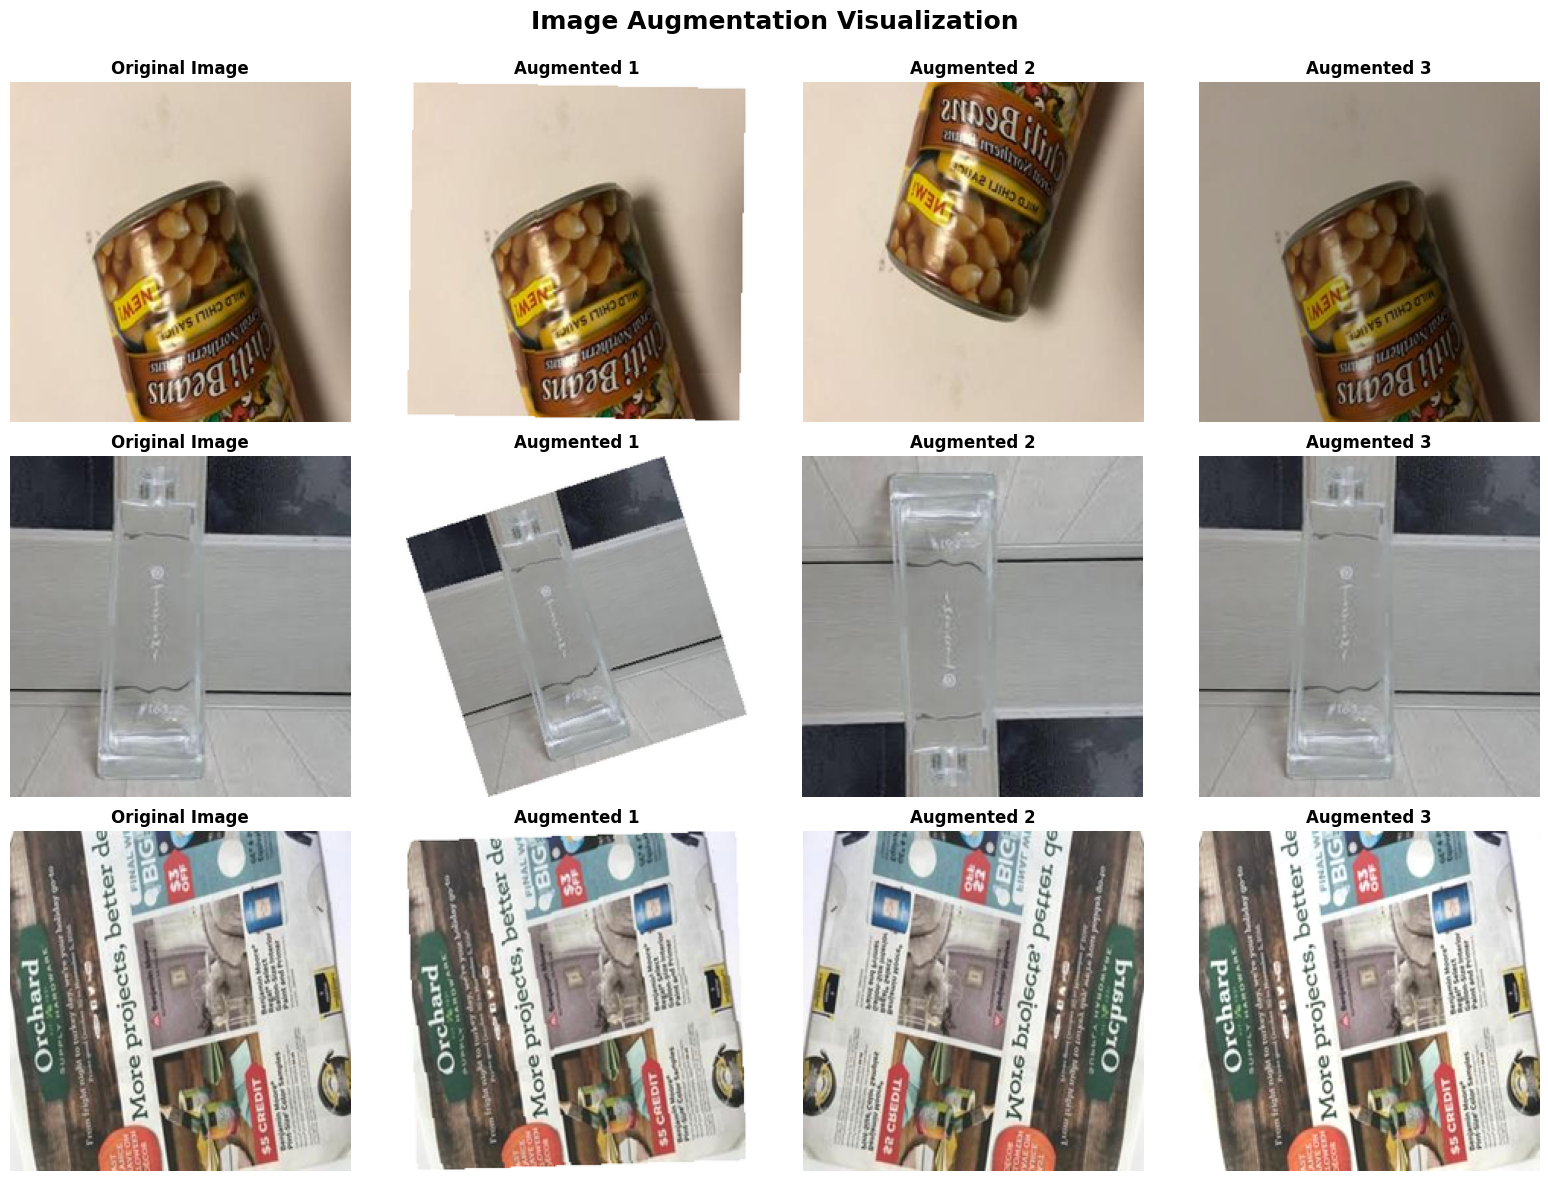

Augmentation visualization saved as: /kaggle/working/augmentation_visualization.png


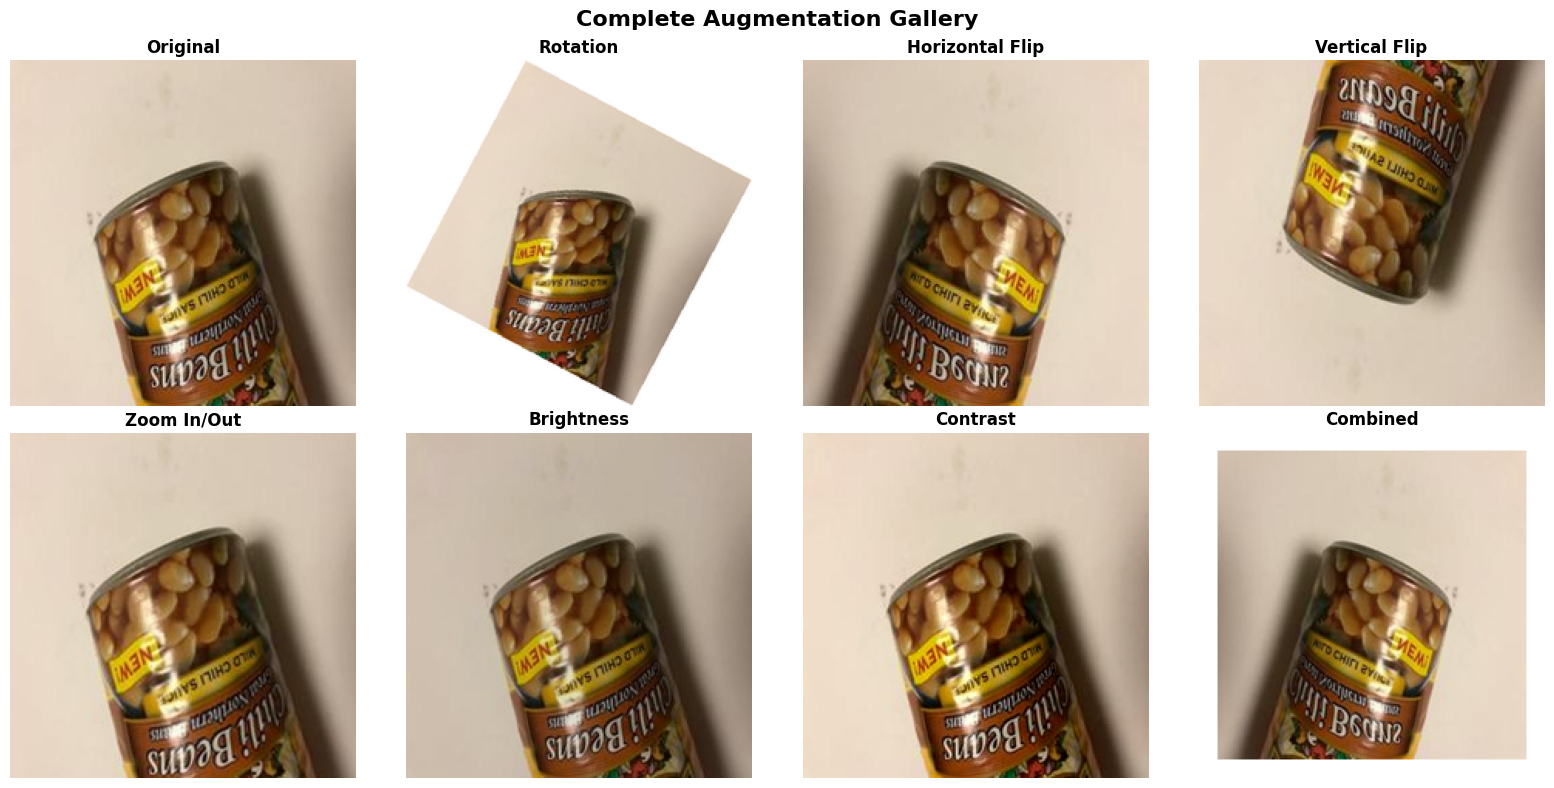

Complete augmentation gallery saved as: /kaggle/working/complete_augmentation_gallery.png
Augmentation visualizations completed!


In [15]:
def show_before_after_samples():
    """
    Display before/after samples in a grid format showing original and augmented versions
    Similar to the format shown in the provided image
    """
    categories = list(stats.keys())
    if not categories:
        print("No processed categories found!")
        return
    
    # Take samples from multiple categories if available
    num_samples = min(3, len(categories))
    sample_categories = categories[:num_samples]
    
    # Create the visualization grid
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    fig.suptitle('Image Augmentation Visualization', fontsize=18, fontweight='bold')
    
    # Handle single row case
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for row, category in enumerate(sample_categories):
        input_path = os.path.join(input_folder, category)
        output_path = os.path.join(output_folder, category)
        
        # Get sample image files
        input_files = [f for f in os.listdir(input_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        if not input_files:
            continue
            
        # Use first available image
        sample_file = input_files[0]
        sample_name = sample_file.split('.')[0]
        
        # Load original image
        original_path = os.path.join(input_path, sample_file)
        original_img = load_image(original_path)
        
        if original_img:
            # Resize original for display
            display_original = resize_image(original_img)
            
            # Column 0: Original Image
            axes[row, 0].imshow(display_original)
            axes[row, 0].set_title('Original Image', fontsize=12, fontweight='bold')
            axes[row, 0].axis('off')
            
            # Generate 3 different augmented versions for display
            augmentation_types = [
                ('Augmented 1', lambda img: apply_random_augmentation(img, 1)),
                ('Augmented 2', lambda img: apply_random_augmentation(img, 2)), 
                ('Augmented 3', lambda img: apply_random_augmentation(img, 3))
            ]
            
            # Columns 1-3: Augmented versions
            for col, (title, aug_func) in enumerate(augmentation_types, 1):
                try:
                    aug_img = aug_func(original_img)
                    if aug_img:
                        axes[row, col].imshow(aug_img)
                        axes[row, col].set_title(title, fontsize=12, fontweight='bold')
                        axes[row, col].axis('off')
                    else:
                        axes[row, col].text(0.5, 0.5, 'Error', ha='center', va='center')
                        axes[row, col].set_title(title, fontsize=12, fontweight='bold')
                        axes[row, col].axis('off')
                except Exception as e:
                    axes[row, col].text(0.5, 0.5, 'Error', ha='center', va='center')
                    axes[row, col].set_title(title, fontsize=12, fontweight='bold')
                    axes[row, col].axis('off')
    
    # Adjust layout and save
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig('/kaggle/working/augmentation_visualization.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.show()
    
    print("Augmentation visualization saved as: /kaggle/working/augmentation_visualization.png")

def apply_random_augmentation(image, aug_type):
    """
    Apply specific augmentation based on type for consistent visualization
    """
    # Resize first
    img = resize_image(image)
    
    if aug_type == 1:
        # Rotation
        img = rotate_image(img)
        img = resize_image(img)  # Resize after rotation to maintain dimensions
    elif aug_type == 2:
        # Flip (alternate between horizontal and vertical)
        if random.choice([True, False]):
            img = flip_horizontal(img)
        else:
            img = flip_vertical(img)
    elif aug_type == 3:
        # Brightness/Contrast adjustment
        if random.choice([True, False]):
            img = adjust_brightness(img)
        else:
            img = adjust_contrast(img)
    
    return img

# Alternative function for showing specific augmentation types
def show_augmentation_gallery():
    """
    Show a comprehensive gallery of all augmentation types applied to sample images
    """
    categories = list(stats.keys())
    if not categories:
        print("No processed categories found!")
        return
    
    # Get sample from first category
    sample_category = categories[0]
    input_path = os.path.join(input_folder, sample_category)
    
    input_files = [f for f in os.listdir(input_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    if not input_files:
        return
    
    sample_file = input_files[0]
    original_path = os.path.join(input_path, sample_file)
    original_img = load_image(original_path)
    
    if not original_img:
        return
    
    # Create 2x4 grid showing all augmentation types
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Complete Augmentation Gallery', fontsize=16, fontweight='bold')
    
    # Flatten axes for easier indexing
    axes_flat = axes.flatten()
    
    # Original image
    resized_original = resize_image(original_img)
    axes_flat[0].imshow(resized_original)
    axes_flat[0].set_title('Original', fontsize=12, fontweight='bold')
    axes_flat[0].axis('off')
    
    # All augmentation types
    augmentations = [
        ('Rotation', lambda: resize_image(rotate_image(resize_image(original_img)))),
        ('Horizontal Flip', lambda: flip_horizontal(resize_image(original_img))),
        ('Vertical Flip', lambda: flip_vertical(resize_image(original_img))),
        ('Zoom In/Out', lambda: zoom_image(resize_image(original_img))),
        ('Brightness', lambda: adjust_brightness(resize_image(original_img))),
        ('Contrast', lambda: adjust_contrast(resize_image(original_img))),
        ('Combined', lambda: apply_combined_augmentation(original_img))
    ]
    
    for i, (title, aug_func) in enumerate(augmentations, 1):
        try:
            aug_img = aug_func()
            axes_flat[i].imshow(aug_img)
            axes_flat[i].set_title(title, fontsize=12, fontweight='bold')
            axes_flat[i].axis('off')
        except Exception as e:
            axes_flat[i].text(0.5, 0.5, f'Error\n{title}', ha='center', va='center')
            axes_flat[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/complete_augmentation_gallery.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Complete augmentation gallery saved as: /kaggle/working/complete_augmentation_gallery.png")

def apply_combined_augmentation(image):
    """
    Apply multiple augmentations together for combined effect
    """
    img = resize_image(image)
    
    # Apply 2-3 random augmentations
    num_augs = random.randint(2, 3)
    applied_augs = random.sample([1, 2, 3, 4, 5], num_augs)
    
    for aug in applied_augs:
        if aug == 1:
            img = rotate_image(img)
            img = resize_image(img)
        elif aug == 2:
            img = flip_horizontal(img)
        elif aug == 3:
            img = zoom_image(img)
        elif aug == 4:
            img = adjust_brightness(img)
        elif aug == 5:
            img = adjust_contrast(img)
    
    return img

# Execute both visualization functions
print("Creating augmentation visualizations...")
show_before_after_samples()
show_augmentation_gallery()
print("Augmentation visualizations completed!")


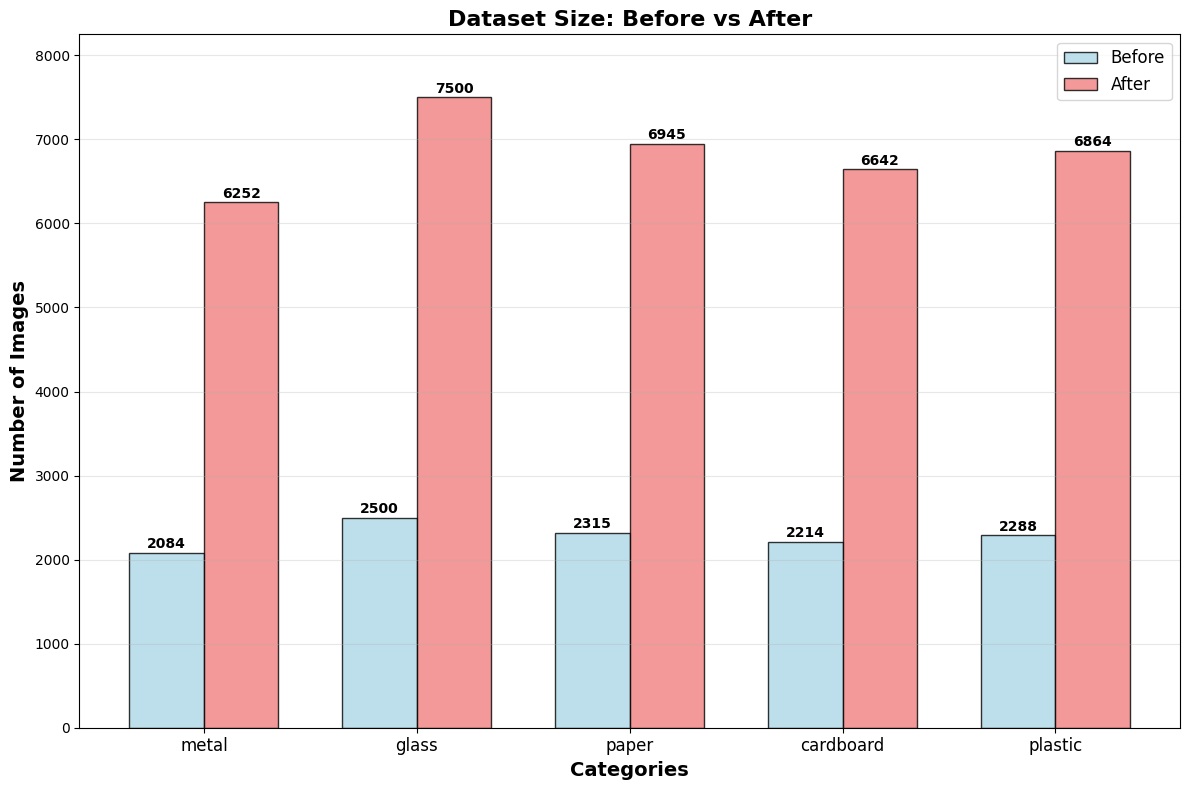

Before vs After bar chart saved as: /kaggle/working/before_after_bar_chart.png


In [16]:
def create_before_after_bar_chart():
    """
    Create bar chart showing dataset size before vs after preprocessing
    """
    # Prepare data
    categories = list(stats.keys())
    before_counts = [stats[cat]['original_files'] for cat in categories]
    after_counts = [stats[cat]['total_output'] for cat in categories]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Set positions for bars
    x_pos = np.arange(len(categories))
    width = 0.35
    
    # Create bars
    bars1 = ax.bar(x_pos - width/2, before_counts, width, 
                   label='Before', color='lightblue', alpha=0.8, edgecolor='black')
    bars2 = ax.bar(x_pos + width/2, after_counts, width, 
                   label='After', color='lightcoral', alpha=0.8, edgecolor='black')
    
    # Add value labels on top of bars
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 20,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 20,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # Customize chart
    ax.set_xlabel('Categories', fontsize=14, fontweight='bold')
    ax.set_ylabel('Number of Images', fontsize=14, fontweight='bold')
    ax.set_title('Dataset Size: Before vs After', fontsize=16, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(categories, fontsize=12)
    ax.legend(fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    
    # Set y-axis to start from 0
    ax.set_ylim(0, max(after_counts) * 1.1)
    
    # Improve layout
    plt.tight_layout()
    plt.savefig('/kaggle/working/before_after_bar_chart.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Before vs After bar chart saved as: /kaggle/working/before_after_bar_chart.png")

# Create the bar chart
create_before_after_bar_chart()


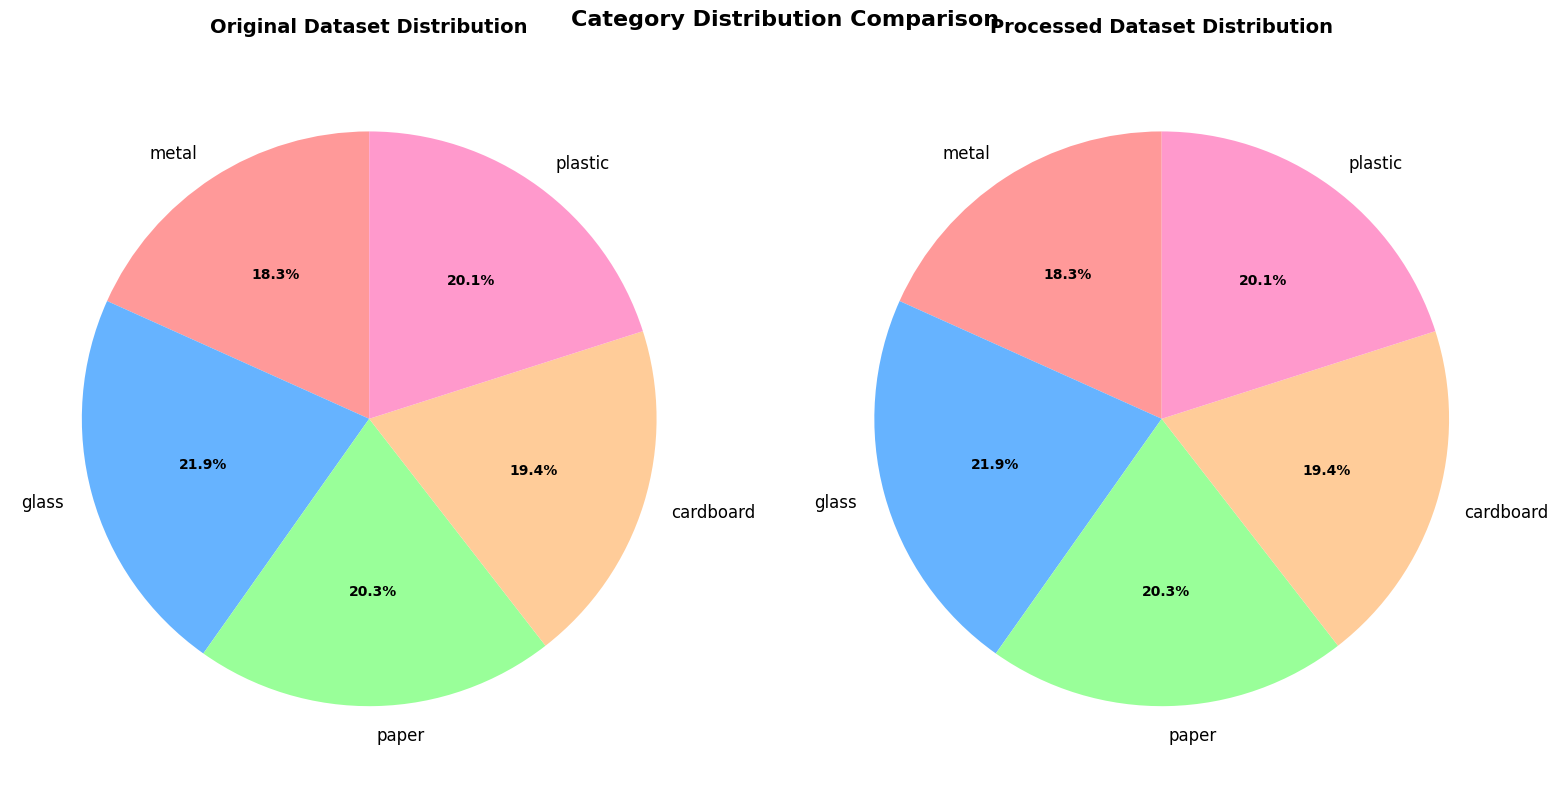

Distribution pie charts saved as: /kaggle/working/distribution_pie_charts.png


In [17]:
def create_distribution_pie_charts():
    """
    Create side-by-side pie charts showing distribution before and after
    """
    # Prepare data
    categories = list(stats.keys())
    before_counts = [stats[cat]['original_files'] for cat in categories]
    after_counts = [stats[cat]['total_output'] for cat in categories]
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Define colors for consistency
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc'][:len(categories)]
    
    # Before pie chart
    wedges1, texts1, autotexts1 = ax1.pie(before_counts, labels=categories, autopct='%1.1f%%', 
                                           startangle=90, colors=colors, textprops={'fontsize': 12})
    ax1.set_title('Original Dataset Distribution', fontsize=14, fontweight='bold', pad=20)
    
    # After pie chart  
    wedges2, texts2, autotexts2 = ax2.pie(after_counts, labels=categories, autopct='%1.1f%%', 
                                           startangle=90, colors=colors, textprops={'fontsize': 12})
    ax2.set_title('Processed Dataset Distribution', fontsize=14, fontweight='bold', pad=20)
    
    # Make percentage text bold
    for autotext in autotexts1 + autotexts2:
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)
    
    # Add overall title
    fig.suptitle('Category Distribution Comparison', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/distribution_pie_charts.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Distribution pie charts saved as: /kaggle/working/distribution_pie_charts.png")

# Create the pie charts
create_distribution_pie_charts()


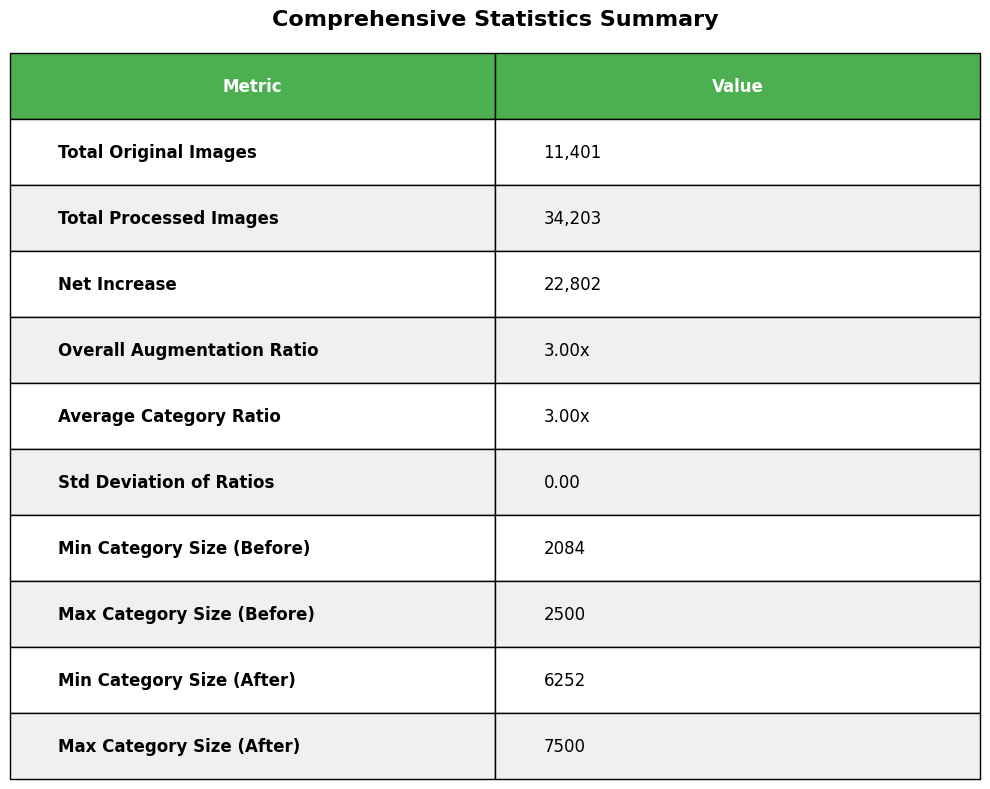

Statistics summary table saved as: /kaggle/working/statistics_summary_table.png


In [18]:
def create_statistics_summary_table():
    """
    Create comprehensive statistics summary table
    """
    # Calculate statistics
    categories = list(stats.keys())
    before_counts = [stats[cat]['original_files'] for cat in categories]
    after_counts = [stats[cat]['total_output'] for cat in categories]
    augmentation_ratios = [stats[cat]['total_output']/stats[cat]['original_files'] for cat in categories]
    
    total_before = sum(before_counts)
    total_after = sum(after_counts)
    overall_ratio = total_after / total_before
    avg_category_ratio = np.mean(augmentation_ratios)
    std_ratios = np.std(augmentation_ratios)
    
    # Create figure for table
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.axis('tight')
    ax.axis('off')
    
    # Prepare table data
    table_data = [
        ['Total Original Images', f"{total_before:,}"],
        ['Total Processed Images', f"{total_after:,}"],
        ['Net Increase', f"{total_after - total_before:,}"],
        ['Overall Augmentation Ratio', f"{overall_ratio:.2f}x"],
        ['Average Category Ratio', f"{avg_category_ratio:.2f}x"],
        ['Std Deviation of Ratios', f"{std_ratios:.2f}"],
        ['Min Category Size (Before)', f"{min(before_counts)}"],
        ['Max Category Size (Before)', f"{max(before_counts)}"],
        ['Min Category Size (After)', f"{min(after_counts)}"],
        ['Max Category Size (After)', f"{max(after_counts)}"]
    ]
    
    # Create table
    table = ax.table(cellText=table_data,
                     colLabels=['Metric', 'Value'],
                     cellLoc='left',
                     loc='center',
                     bbox=[0, 0, 1, 1])
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    
    # Style headers
    for i in range(2):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Style data rows with alternating colors
    for i in range(1, len(table_data) + 1):
        for j in range(2):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#f0f0f0')
            else:
                table[(i, j)].set_facecolor('white')
            
            # Make metric names bold
            if j == 0:
                table[(i, j)].set_text_props(weight='bold')
    
    # Add title
    ax.set_title('Comprehensive Statistics Summary', fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/statistics_summary_table.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Statistics summary table saved as: /kaggle/working/statistics_summary_table.png")

# Create the summary table
create_statistics_summary_table()
